In [ ]:
import pandas as pd
df_price = pd.read_csv("price.csv", encoding='EUC-KR')

In [ ]:
df_price.tail()

,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
524,2025-02-26,56600,-600,-1.05,57000,57100,56100,18117091,1.024930e+12,3.378900e+14,5969782550
525,2025-02-27,56300,-300,-0.53,56500,57100,56200,14975356,8.465310e+11,3.360990e+14,5969782550
526,2025-02-28,54500,-1800,-3.20,55400,55700,54500,28036698,1.540210e+12,3.253530e+14,5969782550
527,2025-03-04,54500,0,0.00,53900,55000,53800,18553933,1.010210e+12,3.253530e+14,5969782550
528,2025-03-05,54000,-500,-0.92,55100,55400,54000,16578817,9.026220e+11,3.223680e+14,5969782550


In [ ]:
import pandas as pd

# 필요한 열만 선택
timeSeries = df_price.loc[:, ["일자", "종가"]]

# '일자' 컬럼을 datetime 형식으로 변환
timeSeries["일자"] = pd.to_datetime(timeSeries["일자"])

# '일자' 컬럼을 인덱스로 설정
timeSeries.set_index("일자", inplace=True)

In [ ]:
# ADF Test
# 귀무가설: 시계열 자료가 정상 시계열이 아니다. (비정상)
# 대립가설: 시계열 자료가 정상 시계열이다.

In [ ]:
# adfuller library
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt

# Check adfuller
def check_adfuller(ts):
  # Dickey-Fuller test
  result = adfuller(ts, autolag='AIC')
  print("Test statistic: ", result[0])
  print("p-value: ", result[1])
  print("Critical Values:", result[4])

# Check mean & std
def check_mean_std(ts):
  # Rolling statistics
  rolmean = ts.rolling(6).mean()
  rolstd = ts.rolling(6).std()

  plt.figure(figsize=(22, 10))
  orig = plt.plot(ts, color='red', label='Original')
  mean = plt.plot(rolmean, color='black', label='Rolling Mean')
  std = plt.plot(rolstd, color='green', label =' Rolling Std')
  plt.xlabel("Date")
  plt.ylabel("Mean Temperature")
  plt.title('Rolling Mean & Standard Deviation')
  plt.legend()
  plt.show()

In [ ]:
check_adfuller(timeSeries)

Test statistic:  -1.2694390832491746
p-value:  0.6430354506098983
Critical Values: {'1%': -3.442843345332837, '5%': -2.867050445147657, '10%': -2.5697048674984457}


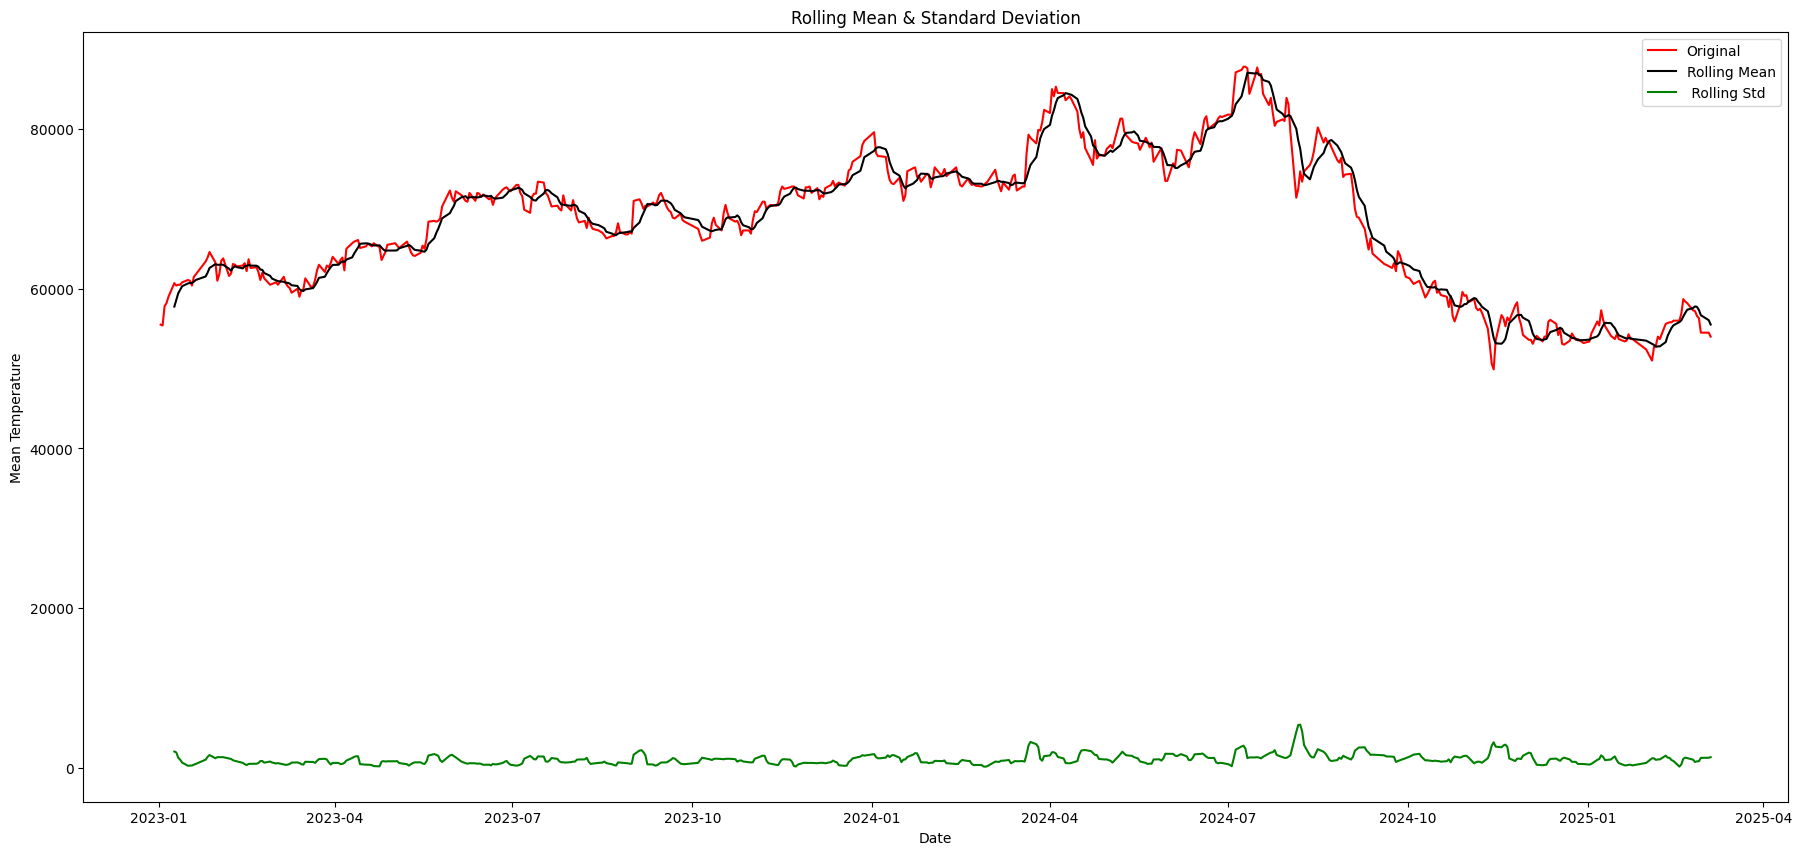

In [ ]:
check_mean_std(timeSeries)

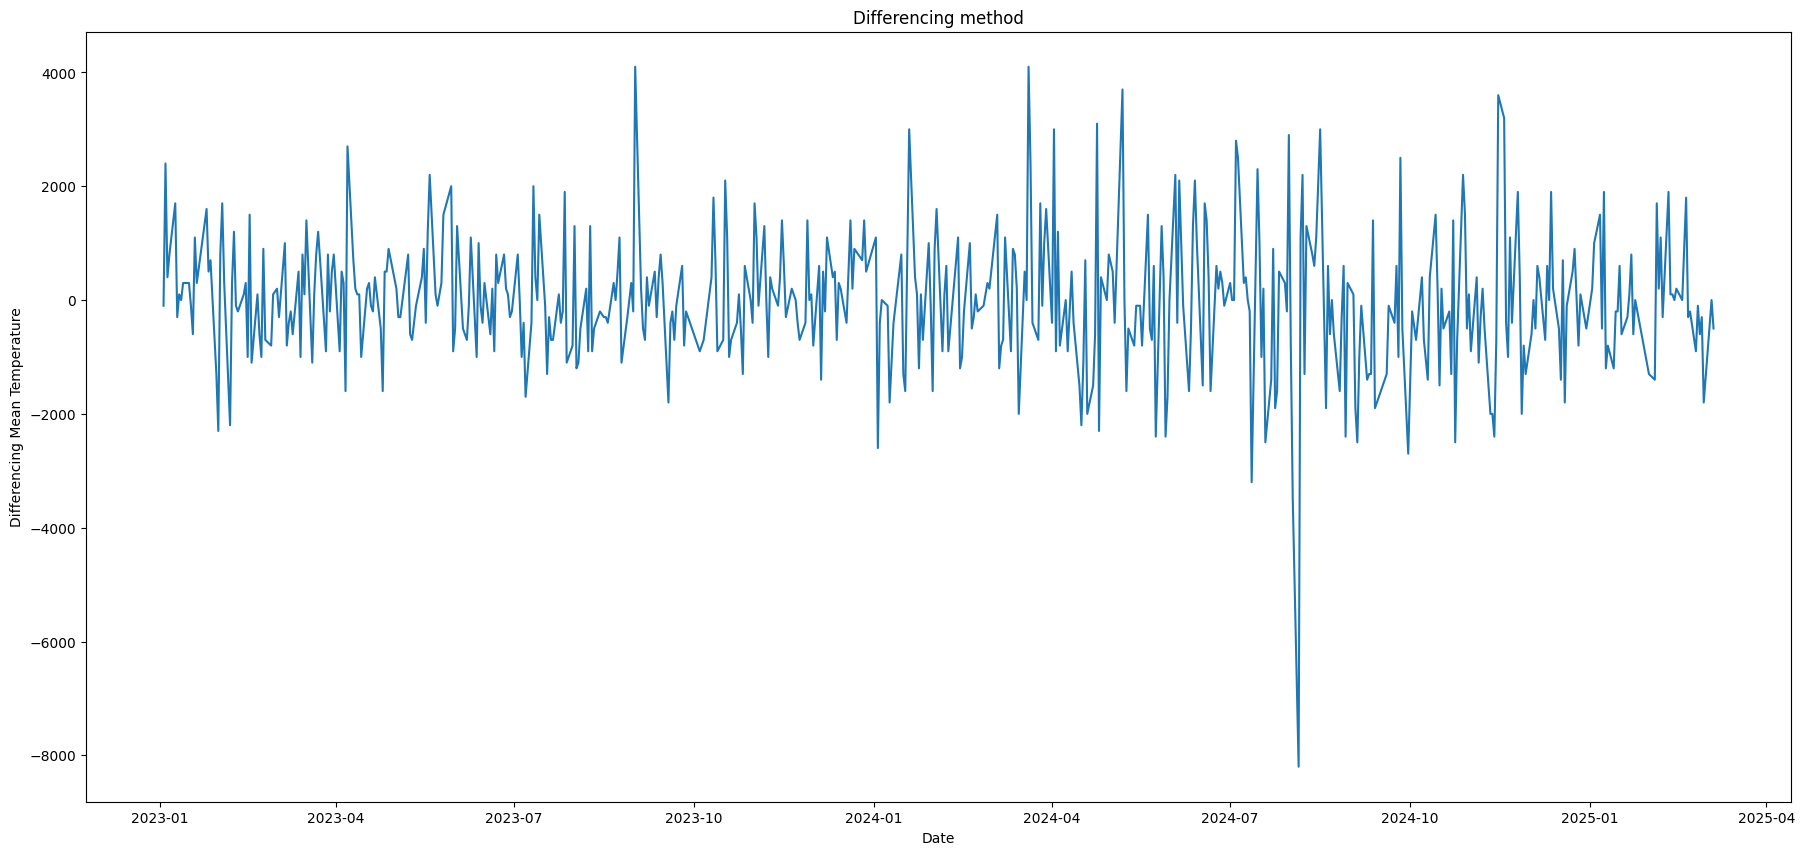

In [ ]:
# differencing method
timeSeries_diff = timeSeries - timeSeries.shift()
plt.figure(figsize=(22, 10))
plt.plot(timeSeries_diff)
plt.title("Differencing method")
plt.xlabel("Date")
plt.ylabel("Differencing Mean Temperature")
plt.show()

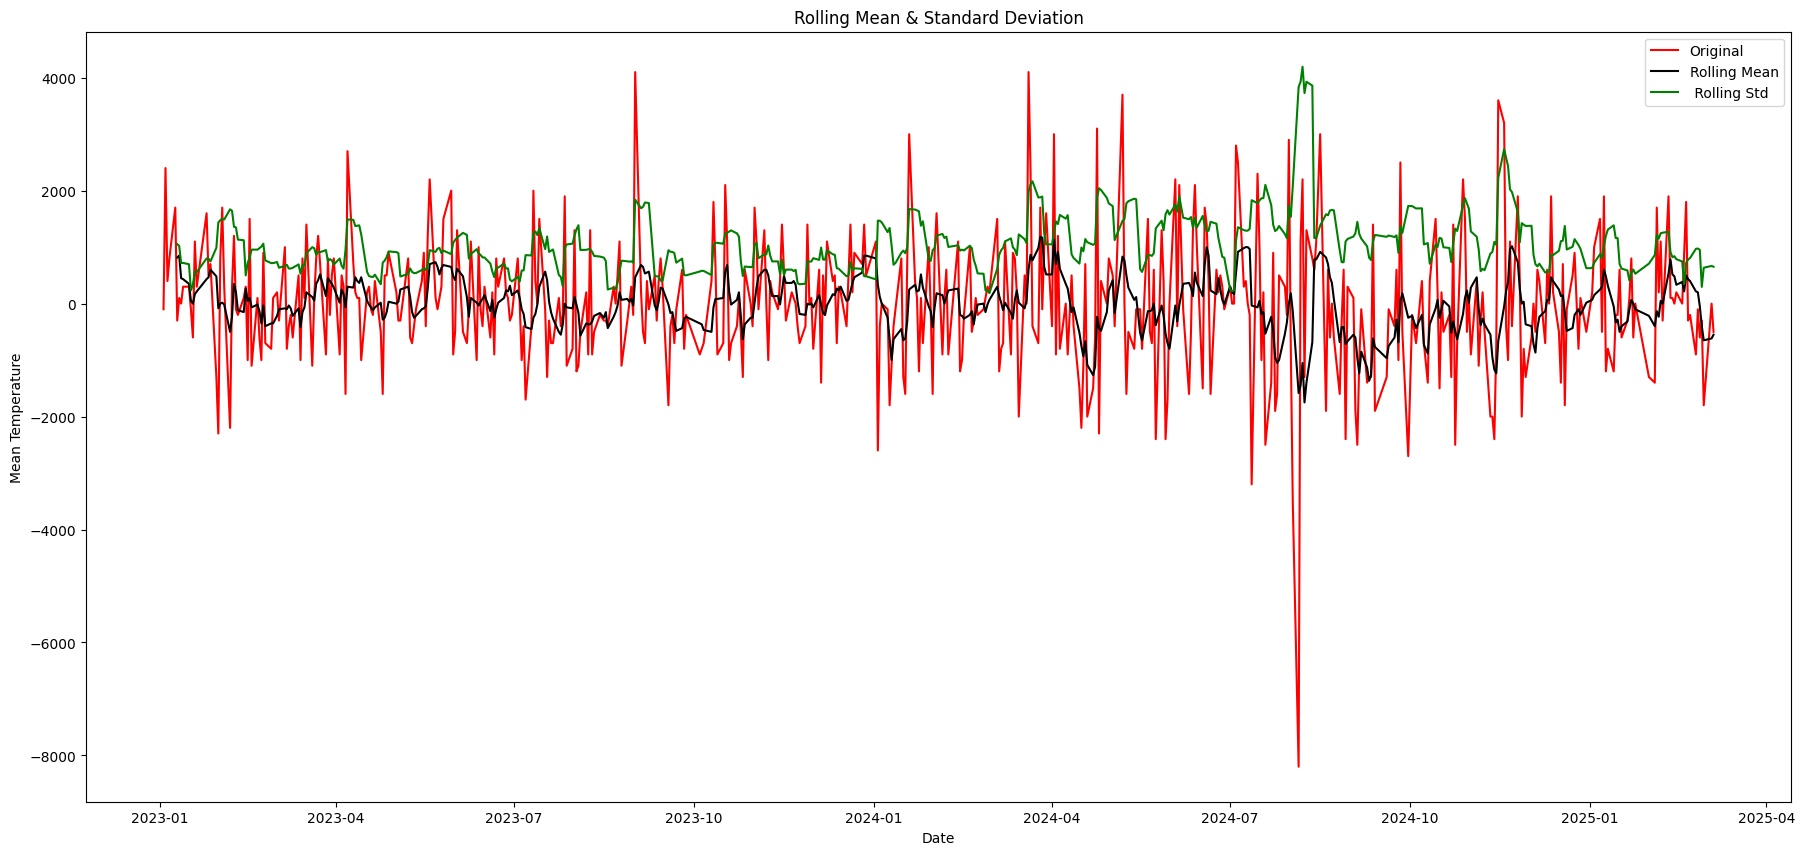

Test statistic:  -17.44949283232199
p-value:  4.661287737056011e-30
Critical Values: {'1%': -3.442843345332837, '5%': -2.867050445147657, '10%': -2.5697048674984457}


In [ ]:
timeSeries_diff.dropna(inplace=True)
check_mean_std(timeSeries_diff)
check_adfuller(timeSeries_diff)

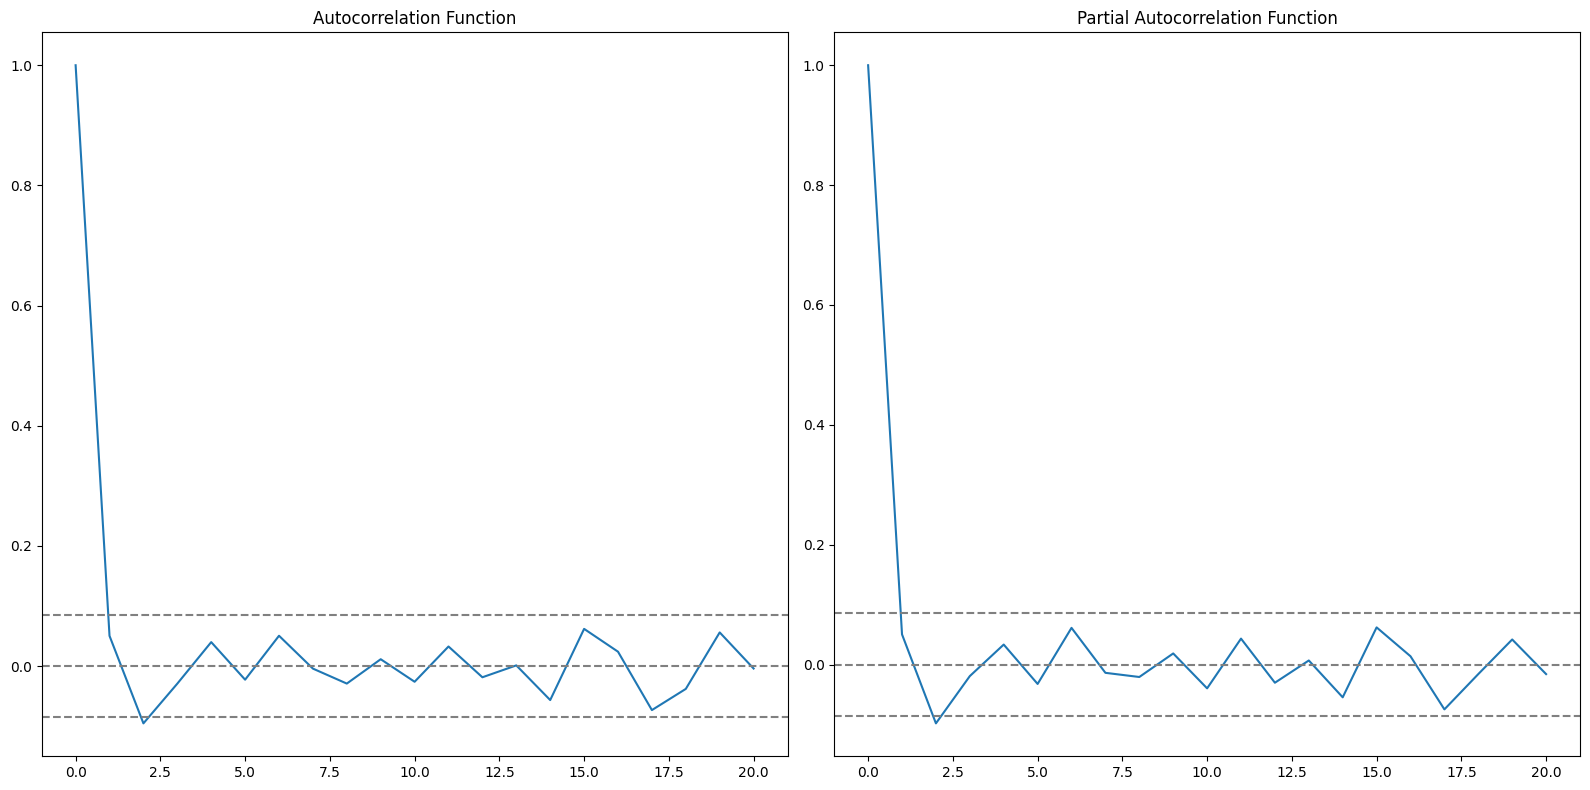

In [ ]:
# ACF and PACF
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
lag_acf = acf(timeSeries_diff, nlags=20)
lag_pacf = pacf(timeSeries_diff, nlags=20, method='ols')
#ACF
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(timeSeries_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(timeSeries_diff)),linestyle='--', color='gray')
plt.title("Autocorrelation Function")

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(timeSeries_diff)),linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(timeSeries_diff)),linestyle='--', color='gray')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Mean Squared Error: 2727463.3209563997
Mean Absolute Error (MAE): 1236.6877080097672


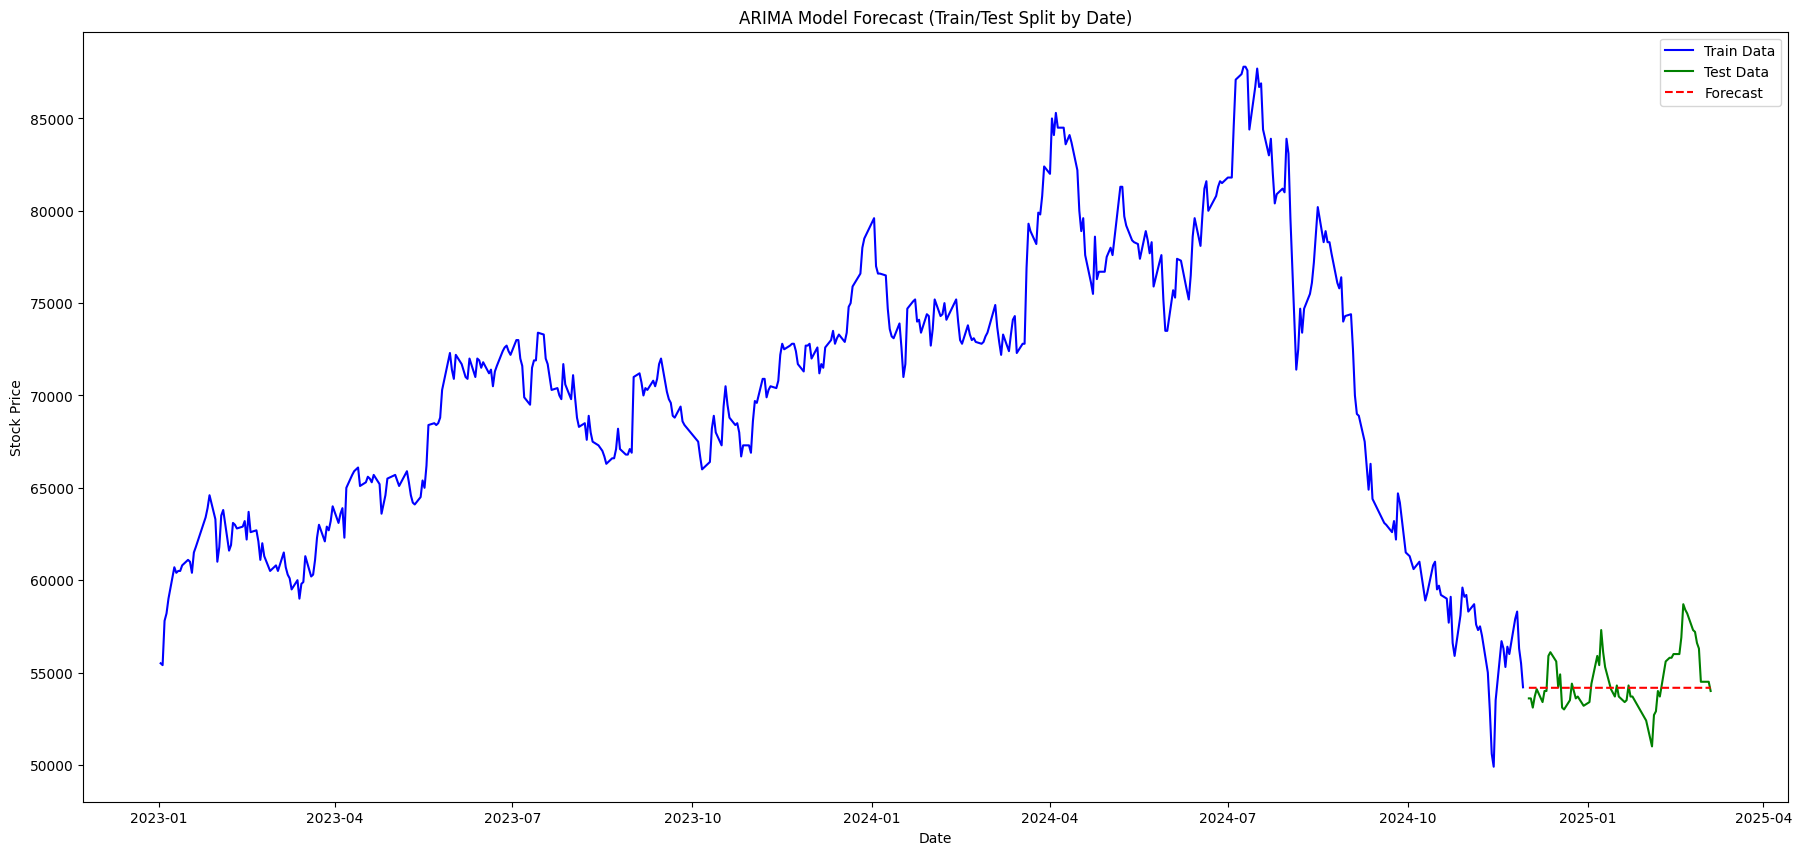

In [ ]:
# 필요한 라이브러리
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 학습 및 테스트 데이터 나누기 (날짜 기반)
train = timeSeries.loc[:'2024-11-29']
test = timeSeries[timeSeries.index > "2024-11-29"]

# ARIMA 모델 학습 (차분 포함)
model = ARIMA(train["종가"], order=(1,1,1))
model_fit = model.fit()

# 예측 수행 (학습 데이터 이후의 기간)
forecast = model_fit.forecast(steps=len(test))

# 예측값의 인덱스를 테스트 데이터의 날짜로 맞추기
forecast.index = test.index

# 성능 평가 (MSE, MAE)
mse = mean_squared_error(test["종가"], forecast)
mae = mean_absolute_error(test["종가"], forecast)

print("Mean Squared Error:", mse)
print("Mean Absolute Error (MAE):", mae)

# 시각화
plt.figure(figsize=(22, 10))
plt.plot(train, label='Train Data', color='blue')
plt.plot(test, label='Test Data', color='green')
plt.plot(forecast, label='Forecast', linestyle='--', color='red')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("ARIMA Model Forecast (Train/Test Split by Date)")
plt.legend()
plt.show()

In [ ]:
"""
# 필요한 라이브러리 불러오기
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ARIMA 모델 학습
model = ARIMA(timeSeries, order=(2,1,2))  # (p,d,q) 값 기본 설정
model_fit = model.fit()

# 예측할 날짜 범위 설정
start_date = "2024-12-01"  # 2024-12-01(일요일) 제외하고 12-02(월)부터 예측 시작
end_date = "2025-03-02"

# ✅ `timeSeries.index`에서 실제 존재하는 날짜만 필터링 (공휴일 및 주말 제외)
valid_dates = timeSeries.loc[start_date:end_date].index  # 실제 데이터에서 존재하는 날짜만 가져오기

# 예측을 위한 시작/종료 인덱스 설정
start_index = timeSeries.index.get_loc(valid_dates[0])  # 예측 시작 인덱스
end_index = timeSeries.index.get_loc(valid_dates[-1])  # 예측 종료 인덱스

# 예측 수행
forecast = model_fit.predict(start=start_index, end=end_index)

# 예측값과 실제값 비교하여 MSE 계산
actual_values = timeSeries.loc[valid_dates]  # 실제 존재하는 날짜의 주가 데이터 가져오기
error = mean_squared_error(actual_values, forecast)
print("Mean Squared Error:", error)

# ✅ MAE (Mean Absolute Error) 계산
mae = mean_absolute_error(actual_values, forecast)
print("Mean Absolute Error (MAE):", mae)

# 시각화
plt.figure(figsize=(22, 10))
plt.plot(timeSeries, label='Original')  # 기존 데이터 전체 그래프
plt.plot(valid_dates, forecast, label='Predicted', linestyle="dashed", color='red')  # 예측값
plt.title("Time Series Forecast (Matching Existing Dates)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()
"""

'\n# 필요한 라이브러리 불러오기\nfrom statsmodels.tsa.arima.model import ARIMA\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error\n\n# ARIMA 모델 학습\nmodel = ARIMA(timeSeries, order=(2,1,2))  # (p,d,q) 값 기본 설정\nmodel_fit = model.fit()\n\n# 예측할 날짜 범위 설정\nstart_date = "2024-12-01"  # 2024-12-01(일요일) 제외하고 12-02(월)부터 예측 시작\nend_date = "2025-03-02"\n\n# ✅ `timeSeries.index`에서 실제 존재하는 날짜만 필터링 (공휴일 및 주말 제외)\nvalid_dates = timeSeries.loc[start_date:end_date].index  # 실제 데이터에서 존재하는 날짜만 가져오기\n\n# 예측을 위한 시작/종료 인덱스 설정\nstart_index = timeSeries.index.get_loc(valid_dates[0])  # 예측 시작 인덱스\nend_index = timeSeries.index.get_loc(valid_dates[-1])  # 예측 종료 인덱스\n\n# 예측 수행\nforecast = model_fit.predict(start=start_index, end=end_index)\n\n# 예측값과 실제값 비교하여 MSE 계산\nactual_values = timeSeries.loc[valid_dates]  # 실제 존재하는 날짜의 주가 데이터 가져오기\nerror = mean_squared_error(actual_values, forecast)\nprint("Mean Squared Error:", error)\n\n# ✅ MAE (Mean Absolute Erro

## seasonal and trend decomposition using loess

In [ ]:
import pandas as pd
df_price = pd.read_csv("price.csv", encoding='EUC-KR')

In [ ]:
len(df_price)

529

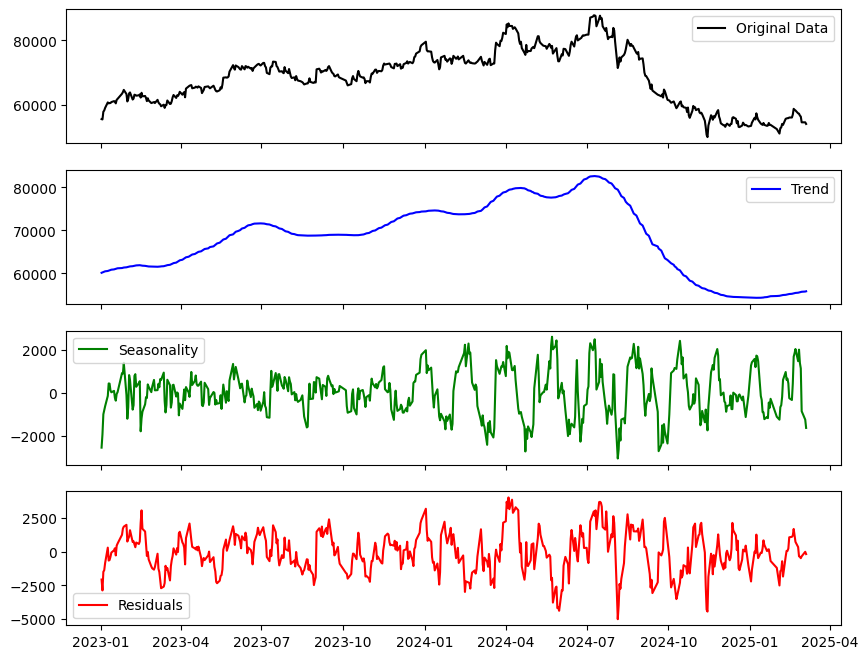

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# 날짜 데이터 변환
df_price['일자'] = pd.to_datetime(df_price['일자'])

# 날짜를 인덱스로 설정
df_price.set_index('일자', inplace=True)

# STL 분해 수행 (기간을 30일로 설정)
stl = STL(df_price['종가'], period=30)
result = stl.fit()

# 결과 시각화
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

axes[0].plot(df_price['종가'], label="Original Data", color="black")
axes[0].legend()

axes[1].plot(result.trend, label="Trend", color="blue")
axes[1].legend()

axes[2].plot(result.seasonal, label="Seasonality", color="green")
axes[2].legend()

axes[3].plot(result.resid, label="Residuals", color="red")
axes[3].legend()

plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

MSE: 215389.18
MAE: 341.56


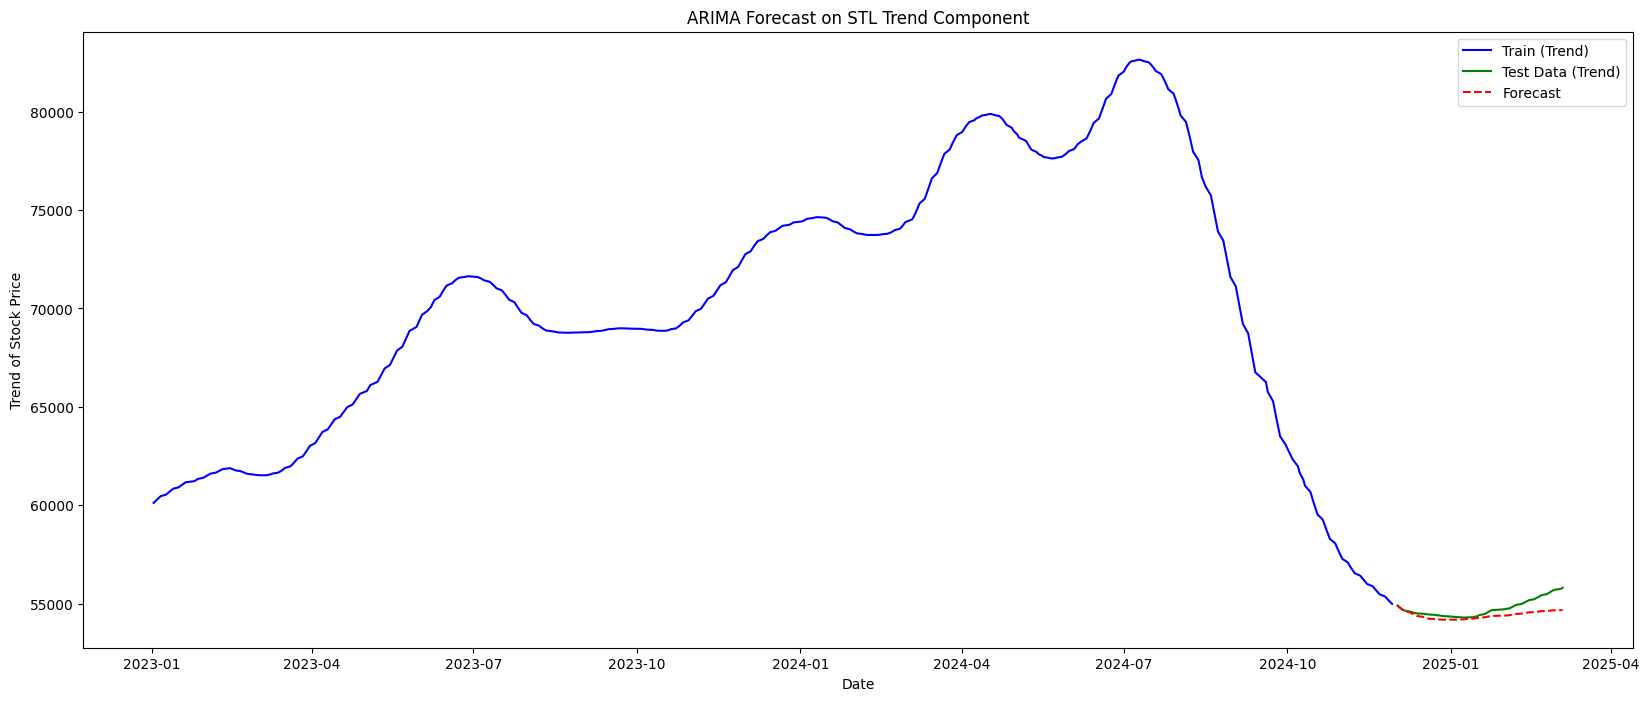

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# STL 추세성분에서 결측치 제거
stl_trend = result.trend.dropna()

# 학습 데이터(2024-11-29까지), 테스트 데이터(이후)로 명시적 분리
train_trend = stl_trend[stl_trend.index <= '2024-11-29']
test_trend = stl_trend[stl_trend.index > '2024-11-29']

# ARIMA 모델 학습 (추세 성분 기반)
model = ARIMA(train_trend, order=(2,1,2))
model_fit = model.fit()

# 예측 수행 (테스트 데이터 길이만큼)
forecast = model_fit.forecast(steps=len(test_trend))

# forecast 결과의 index를 test 데이터의 index로 지정
forecast.index = test_trend.index

# 성능 평가
mse = mean_squared_error(test_trend, forecast)
mae = mean_absolute_error(test_trend, forecast)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

# 시각화
plt.figure(figsize=(20,8))
plt.plot(train_trend, label='Train (Trend)', color='blue')
plt.plot(test_trend, label='Test Data (Trend)', color='green')
plt.plot(forecast, label='Forecast', linestyle='--', color='red')
plt.title("ARIMA Forecast on STL Trend Component")
plt.xlabel("Date")
plt.ylabel("Trend of Stock Price")
plt.legend()
plt.show()

In [ ]:
stl_trend

,trend
일자,
2023-01-02,60117.454256
2023-01-03,60206.396378
2023-01-04,60293.132138
2023-01-05,60377.619006
2023-01-06,60459.841155
...,...
2025-02-26,55586.869614
2025-02-27,55641.294617
2025-02-28,55696.179451


## seasonal and trend decomposition using loess -- 부트스트랩

In [ ]:
import pandas as pd
df_price = pd.read_csv("price.csv", encoding='EUC-KR')

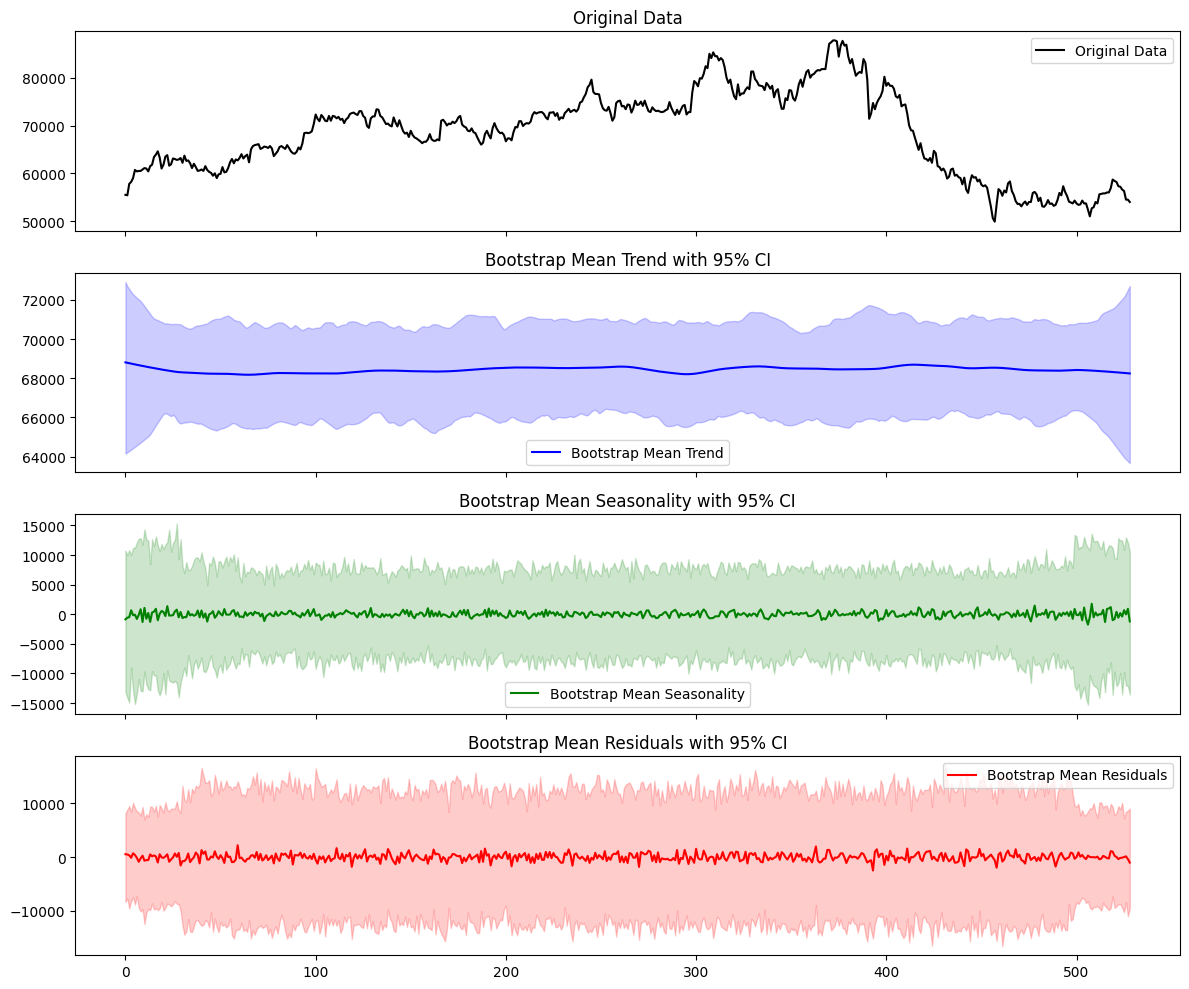

In [ ]:
import numpy as np
from statsmodels.tsa.seasonal import STL

# Bootstrap 설정
n_bootstrap = 100  # 부트스트랩 샘플 개수

# 원본 데이터 길이
n = len(df_price['종가'])

# STL 결과를 저장할 배열 초기화
bootstrap_trends = np.zeros((n, n_bootstrap))
bootstrap_seasonals = np.zeros((n, n_bootstrap))
bootstrap_residuals = np.zeros((n, n_bootstrap))

# Bootstrap을 통해 여러 번 STL 분해 수행
for i in range(n_bootstrap):
    sample = df_price['종가'].sample(n=n, replace=True, random_state=i)  # 부트스트랩 샘플링
    sample.index = df_price.index  # 원본 인덱스 유지

    # STL 분해 적용 (30일 주기)
    stl_sample = STL(sample, period=30).fit()

    # 결과 저장
    bootstrap_trends[:, i] = stl_sample.trend
    bootstrap_seasonals[:, i] = stl_sample.seasonal
    bootstrap_residuals[:, i] = stl_sample.resid

# Bootstrap 결과의 평균 및 신뢰 구간(95% 신뢰구간) 계산
mean_trend = np.mean(bootstrap_trends, axis=1)
mean_seasonal = np.mean(bootstrap_seasonals, axis=1)
mean_residual = np.mean(bootstrap_residuals, axis=1)

lower_trend = np.percentile(bootstrap_trends, 2.5, axis=1)
upper_trend = np.percentile(bootstrap_trends, 97.5, axis=1)

lower_seasonal = np.percentile(bootstrap_seasonals, 2.5, axis=1)
upper_seasonal = np.percentile(bootstrap_seasonals, 97.5, axis=1)

lower_residual = np.percentile(bootstrap_residuals, 2.5, axis=1)
upper_residual = np.percentile(bootstrap_residuals, 97.5, axis=1)

# 결과 시각화
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# 원본 데이터
axes[0].plot(df_price.index, df_price['종가'], label="Original Data", color="black")
axes[0].set_title("Original Data")
axes[0].legend()

# Trend Component (Bootstrap 평균 및 신뢰 구간)
axes[1].plot(df_price.index, mean_trend, label="Bootstrap Mean Trend", color="blue")
axes[1].fill_between(df_price.index, lower_trend, upper_trend, color='blue', alpha=0.2)
axes[1].set_title("Bootstrap Mean Trend with 95% CI")
axes[1].legend()

# Seasonal Component (Bootstrap 평균 및 신뢰 구간)
axes[2].plot(df_price.index, mean_seasonal, label="Bootstrap Mean Seasonality", color="green")
axes[2].fill_between(df_price.index, lower_seasonal, upper_seasonal, color='green', alpha=0.2)
axes[2].set_title("Bootstrap Mean Seasonality with 95% CI")
axes[2].legend()

# Residual Component (Bootstrap 평균 및 신뢰 구간)
axes[3].plot(df_price.index, mean_residual, label="Bootstrap Mean Residuals", color="red")
axes[3].fill_between(df_price.index, lower_residual, upper_residual, color='red', alpha=0.2)
axes[3].set_title("Bootstrap Mean Residuals with 95% CI")
axes[3].legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Mean Squared Error (MSE): 3167.5892369056487
Mean Absolute Error (MAE): 37.0942744962158


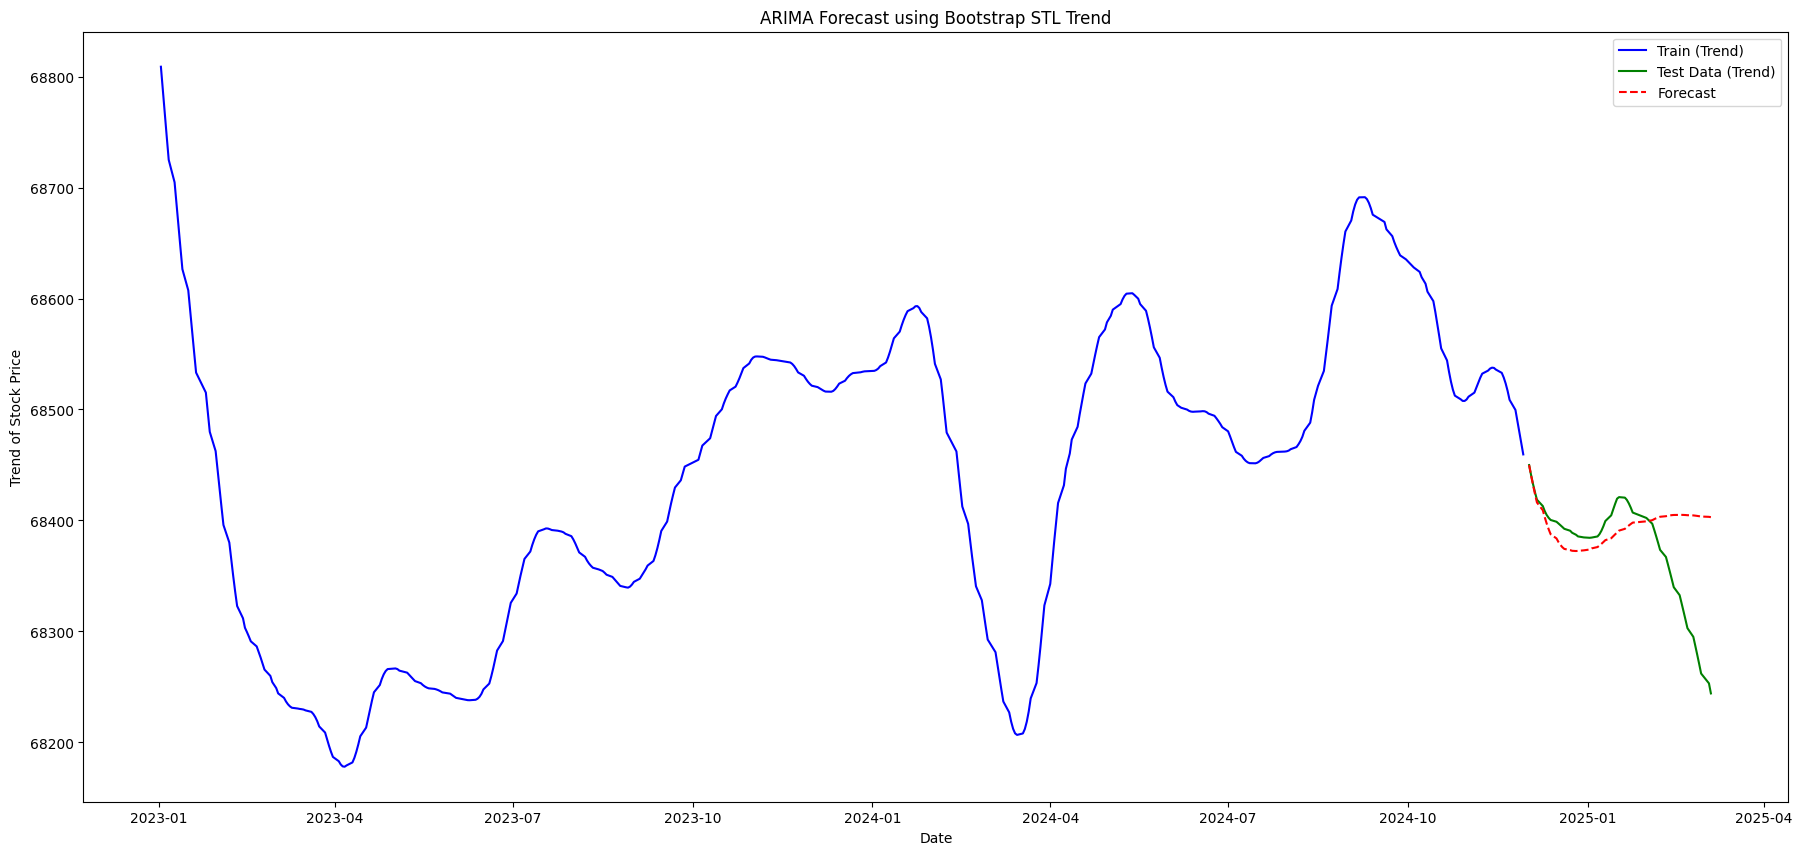

In [ ]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 날짜 변환 및 인덱스 설정
df_price['일자'] = pd.to_datetime(df_price['일자'])
df_price.set_index('일자', inplace=True)

# STL 분해 후 bootstrap
n_bootstrap = 100
n = len(df_price)

bootstrap_trends = np.zeros((n, n_bootstrap))

# Bootstrap 샘플링을 통한 STL 분해
for i in range(n_bootstrap):
    sample = df_price['종가'].sample(n=n, replace=True, random_state=i)
    sample.index = df_price.index

    stl = STL(sample, period=30)
    result = stl.fit()

    bootstrap_trends[:, i] = result.trend

# 추세(trend) 성분의 평균 계산
mean_trend = np.mean(bootstrap_trends, axis=1)

# 날짜 인덱스와 함께 trend Series 생성
bootstrap_trend_series = pd.Series(mean_trend, index=df_price.index).dropna()

# 학습 및 테스트 데이터 나누기
train = bootstrap_trend_series[:'2024-11-29']
test = bootstrap_trend_series['2024-11-30':]

# ARIMA 모델 학습
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit()

# 예측 수행 (테스트 데이터 기간)
forecast = model_fit.forecast(steps=len(test))

# 예측값 인덱스 설정
forecast.index = test.index

# 성능 평가
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

# 시각화
plt.figure(figsize=(22, 10))
plt.plot(train, label='Train (Trend)', color='blue')
plt.plot(test, label='Test Data (Trend)', color='green')
plt.plot(forecast, label='Forecast', linestyle='--', color='red')
plt.xlabel("Date")
plt.ylabel("Trend of Stock Price")
plt.title("ARIMA Forecast using Bootstrap STL Trend")
plt.legend()
plt.show()

## Transformer - 원본

Epoch 1/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.7436 - val_loss: 0.0696
Epoch 2/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1064 - val_loss: 0.0852
Epoch 3/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0626 - val_loss: 0.0383
Epoch 4/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0451 - val_loss: 0.0279
Epoch 5/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0316 - val_loss: 0.0309
Epoch 6/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0278 - val_loss: 0.0444
Epoch 7/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0235 - val_loss: 0.0058
Epoch 8/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 9/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0180 - val_loss: 0.0184
Epoch 10/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0138 - val_loss: 0.0120
Epoch 11/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0163 - val_loss: 0.0448
Epoch 12/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0

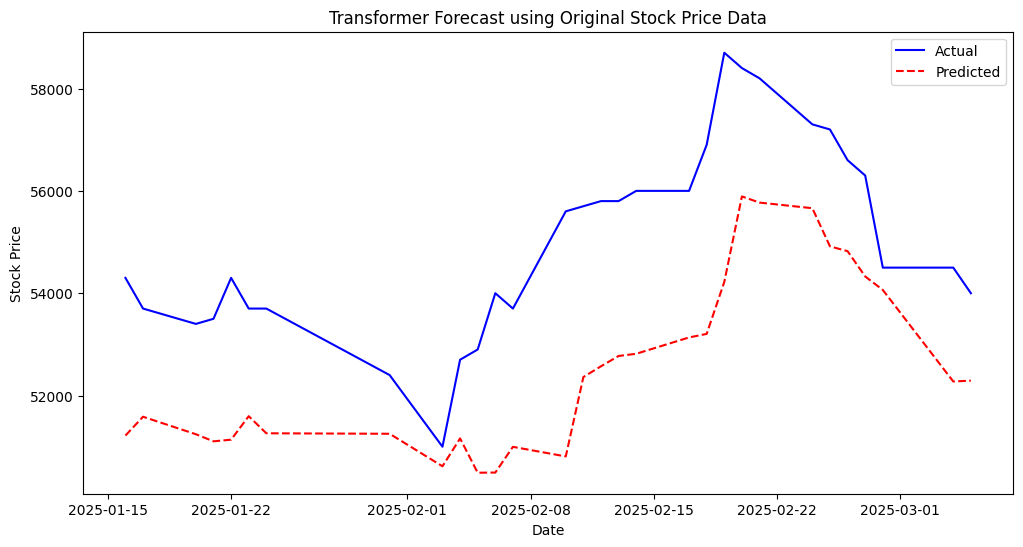

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 🔹 데이터 로드 및 날짜 인덱스 설정
file_path = "price.csv"
df = pd.read_csv(file_path, encoding="EUC-KR")

df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# 🔹 '종가' 데이터 정규화 (MinMaxScaler)
scaler = MinMaxScaler()
df['종가_scaled'] = scaler.fit_transform(df[['종가']])

# 🔹 학습 / 테스트 데이터 분할 (정확한 날짜 기준)
train = df.loc[:'2024-11-29', '종가_scaled']
test = df.loc['2024-11-30':, '종가_scaled']

# 🔹 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # 과거 30일 데이터를 사용하여 예측
X_train, y_train = create_sequences(train.values, seq_length)
X_test, y_test = create_sequences(test.values, seq_length)

# 입력 차원 변환
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 🔹 Transformer 모델 구성
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ffn_units, dropout_rate):
        super(TransformerBlock, self).__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ln1 = LayerNormalization()
        self.ln2 = LayerNormalization()
        self.ffn = tf.keras.Sequential([
            Dense(ffn_units, activation='relu'),
            Dense(d_model)
        ])
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs):
        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.ln1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.ln2(out1 + ffn_output)

        return out2

# 🔹 최적의 하이퍼파라미터 설정
d_model = 32
num_heads = 4
num_layers = 2
ffn_units = 256
dropout_rate = 0.1
learning_rate = 0.0007
batch_size = 32
epochs = 27

# 🔹 Transformer 모델 정의
def build_transformer(seq_length, d_model, num_heads, num_layers, ffn_units, dropout_rate):
    inputs = Input(shape=(seq_length, 1))
    x = Dense(d_model)(inputs)

    for _ in range(num_layers):
        x = TransformerBlock(d_model, num_heads, ffn_units, dropout_rate)(x)

    x = Dense(1)(x[:, -1, :])  # 마지막 타임스텝을 예측
    model = Model(inputs, x)
    return model

# 🔹 모델 생성 및 컴파일
model = build_transformer(seq_length, d_model, num_heads, num_layers, ffn_units, dropout_rate)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# 🔹 학습 실행
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# 🔹 예측 수행
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# 🔹 성능 평가 (MSE, MAE)
mse = np.mean((scaler.inverse_transform(y_test.reshape(-1,1)) - predictions) ** 2)
mae = np.mean(np.abs(scaler.inverse_transform(y_test.reshape(-1,1)) - predictions))

print("🔹 MSE:", mse)
print("🔹 MAE:", mae)

# 🔹 결과 시각화
plt.figure(figsize=(12,6))
plt.plot(test.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual", color='blue')
plt.plot(test.index[-len(predictions):], predictions, label="Predicted", linestyle="dashed", color='red')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Transformer Forecast using Original Stock Price Data")
plt.legend()
plt.show()

## Transformer--stl적용

Epoch 1/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 2.3343 - val_loss: 0.3697
Epoch 2/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2207 - val_loss: 0.2259
Epoch 3/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0893 - val_loss: 0.2468
Epoch 4/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0650 - val_loss: 0.3902
Epoch 5/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0606 - val_loss: 0.3591
Epoch 6/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0561 - val_loss: 0.4463
Epoch 7/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0514 - val_loss: 0.3627
Epoch 8/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0521 - val_loss: 0.2262
Epoch 9/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0451 - val_loss: 0.1640
Epoch 10/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0348 - val_loss: 0.1586
Epoch 11/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0345 - val_loss: 0.0332
Epoch 12/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0

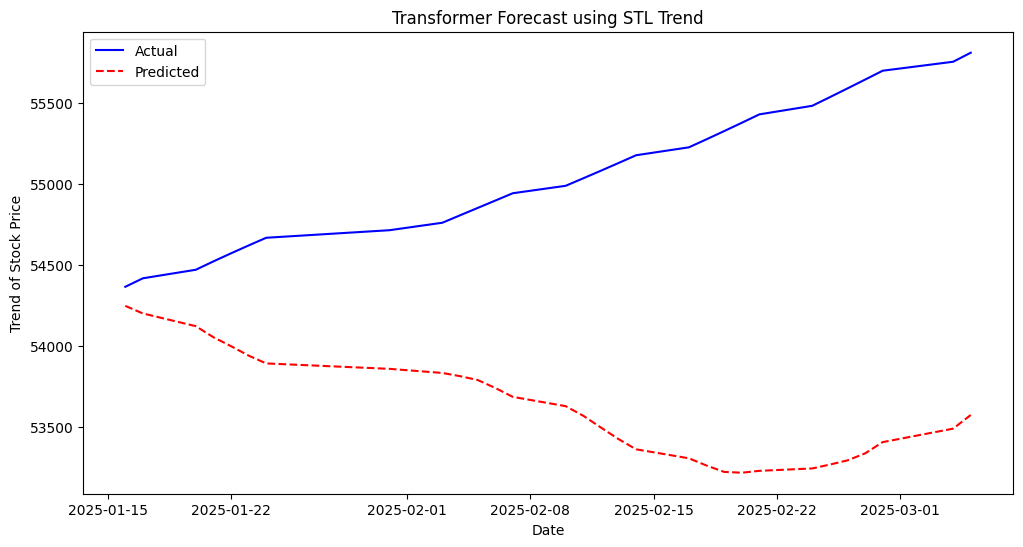

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 🔹 데이터 로드 및 날짜 인덱스 설정
file_path = "price.csv"
df = pd.read_csv(file_path, encoding="EUC-KR")

df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# 🔹 STL을 이용한 추세(trend) 추출
stl = STL(df['종가'], period=30)
stl_result = stl.fit()
stl_trend = stl_result.trend

# 🔹 학습 / 테스트 데이터 분할 (정확한 날짜 기준)
train_trend = stl_trend[stl_trend.index <= '2024-11-29']
test_trend = stl_trend[stl_trend.index > '2024-11-29']

# 🔹 MinMaxScaler로 정규화
scaler = MinMaxScaler()
train_trend_scaled = scaler.fit_transform(train_trend.values.reshape(-1, 1))
test_trend_scaled = scaler.transform(test_trend.values.reshape(-1, 1))

# 🔹 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # 과거 30일 데이터 사용
X_train, y_train = create_sequences(train_trend_scaled, seq_length)
X_test, y_test = create_sequences(test_trend_scaled, seq_length)

# 입력 차원 변환
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 🔹 Transformer 모델 구성
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ffn_units, dropout_rate):
        super(TransformerBlock, self).__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ln1 = LayerNormalization()
        self.ln2 = LayerNormalization()
        self.ffn = tf.keras.Sequential([
            Dense(ffn_units, activation='relu'),
            Dense(d_model)
        ])
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs):
        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.ln1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.ln2(out1 + ffn_output)

        return out2

# 🔹 최적의 하이퍼파라미터 설정
d_model = 32
num_heads = 4
num_layers = 2
ffn_units = 256
dropout_rate = 0.1
learning_rate = 0.0007
batch_size = 32
epochs = 27

# 🔹 Transformer 모델 정의
def build_transformer(seq_length, d_model, num_heads, num_layers, ffn_units, dropout_rate):
    inputs = Input(shape=(seq_length, 1))
    x = Dense(d_model)(inputs)

    for _ in range(num_layers):
        x = TransformerBlock(d_model, num_heads, ffn_units, dropout_rate)(x)

    x = Dense(1)(x[:, -1, :])  # 마지막 타임스텝 예측
    model = Model(inputs, x)
    return model

# 🔹 모델 생성 및 컴파일
model = build_transformer(seq_length, d_model, num_heads, num_layers, ffn_units, dropout_rate)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# 🔹 학습 실행
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# 🔹 예측 수행
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# 🔹 성능 평가 (MSE, MAE)
mse = np.mean((scaler.inverse_transform(y_test.reshape(-1,1)) - predictions) ** 2)
mae = np.mean(np.abs(scaler.inverse_transform(y_test.reshape(-1,1)) - predictions))

print("🔹 MSE:", mse)
print("🔹 MAE:", mae)

# 🔹 결과 시각화
plt.figure(figsize=(12,6))
plt.plot(test_trend.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual", color='blue')
plt.plot(test_trend.index[-len(predictions):], predictions, label="Predicted", linestyle="dashed", color='red')
plt.xlabel("Date")
plt.ylabel("Trend of Stock Price")
plt.title("Transformer Forecast using STL Trend")
plt.legend()
plt.show()
